# How (Not) to Invest I: Moving Average Convergence/Divergence
When I first started exploring the world of technical analysis, the first indicator I came across was the Moving Average Convergence/Divergence (MACD) oscillator, a popular indicator for measuring stock momentum and following the trend of a stock's price. Although many websites (e.g. [Investopedia](https://www.investopedia.com/slide-show/tools-of-the-trade/), [BusinessInsider](https://www.businessinsider.com/stock-traders-swear-by-these-12-technical-indicators-2017-5/?IR=T), [MoneyShow](https://www.moneyshow.com/articles/daytraders-31201/)) touted the MACD as an "essential" indicator for technical trading, I wasn't quite sold on the fact that following "a few simple trading rules" could allow me to consistently make money from trading. And, like most people, I did not know how to back-test trading strategies at that time.  
  
However, now that I know a little bit of programming, I have decided to write a series of posts on the effectiveness of technical trading entitled *How (Not) to Invest*. This first post in the series is on the MACD.  
  
# The Evolution of Technical Indicators
As a start to the series on *How (Not) to Invest*, it is appropriate to articulate my theory on the evolution of technical indicators, which borrows from cryptography. In cryptography, there are *codemakers* who devise encryption algorithms, and codebreakers who aim to break them. Once encryption algorithms are broken, new ones are created. That tension leads to stronger and more complex encryption. Technical indicators appear to work in the same way.  
  
Today, there are [many trading indicators](https://stockcharts.com/school/doku.php?id=chart_school:technical_indicators) at our disposal. And I believe these came about from the cycle of people devising new indicators and others exploiting them, leading to the creation of new ones. The main point here is that once indicators are released for mass consumption, they cease to be effective as a critical mass of traders act on these signals. As such, it is my opinion that **when employed in too simple a fashion, too slowly, or both, existing technical indicators cannot deliver positive excess returns**.  
  
However, machine learning (ML) may provide hope for technical trading. First, new and more complex indicators are developed when the old ones don't work - this is equivalent to feature generation in ML. Second, employing new and existing indicators in complex ways could make *systems of indicators* work - this can be achieved using ML algorithms.  
  
*How (Not) to Invest* will test these hypotheses.  

# On MACD
Having addressed my boring general theory on why indicators don't work, we can now dive into MACD, the subject of this post.  
  
## The Basics
The MACD indicator comprises three lines: a fast exponential moving average (EMA), a slow EMA, and an EMA of the difference between the fast and the slow EMAs. The typical setting is `12/26/9`, and means that we use a (fast) **12-day EMA**, a (slow) **26-day EMA**, and a **9-day EMA** of the difference between the prior two EMAs. This difference between the fast and slow EMAs can be though of as the pressure on price in the near term (fast EMA) vs. the pressure on price in the slightly longer term (slow EMA). The quicker prices are rising, the quicker the increase in the fast EMA.

## Trade Signals
The MACD has two main signals for buying and selling: the **centerline crossover** trigger and the **signal line crossover** trigger. First, the centerline crossover trigger is when the MACD line (different between fast EMA and slow EMA) rises above/below zero. Second, the signal line crossover trigger is when the MACD line crosses above/below the signal line. We can interpret both signals as increasing upward/downward momentum in prices.  
  
# Trading Simulations
In our trading simulations, we will hard-code the MACD triggers, apply different EMA settings, and test them out on all stocks in the S&P 500. We will also calculate returns and accuracy metrics (precision and recall) to evaluate each MACD configuration.  
  
## Evaluation Metrics
To evaluate the effectiveness of MACD on the S&P 500 stocks, I compute (1) returns, (2) precision, and (3/4) the excess of returns and precision over the baselines.  
  
### Returns
In the simulations, I used 5-day, 10-day, and 20-day forward returns. Having multiple trading horizons increases the probability of finding winning strategies. Therefore, if we fail to find any profitable MACD strategies, we would have higher confidence that MACD strategies do not work.  
  
### Excess Returns
I used the buy-and-hold returns of each stock as the benchmark. Excess returns were therefore defined as the returns from the MACD trading strategy *minus* the buy-and-hold returns.  
  
### Precision
Precision is the proportion of predicted positives that were actually positive. In our case, it is the percentage of *predicted* profitable trades that were in fact profitable. This allows us to assess how often the MACD indicator gives us signals that are correct.
  
### Precision Advantage
The precision advantage defines how precise the MACD indicator is relative to a naive guess. Suppose a stock's 10-day returns is positive 60% of the time and negative 40% of the time. A naive guess would be to guess the more popular outcome: positive. If the MACD indicator guesses that the returns are positive only 30% of the time, we would have been better off going with the naive guess.  
  
## The Rules
In our trading simulation, we used the following rules:  
  
1. Only long trades allowed
2. Trades are executed when a buy signal is triggered  
    a. **Centerline crossover (CC):** Signal line crosses above zero  
    b. **Signal line crossover (SLC):** The MACD line crosses above the signal line + the MACD line is above zero
  
We used the following parameters:  
  
1. **Returns:** 5-day, 10-day, and 20-day (separately)
2. **Fast EMA:** 2, 3, 4, and 5 times the forward returns period
3. **Slow EMA:** 2, 3, 4, and 5 times the fast EMA setting
4. **Signal Line:** 4, 8, 12, 16, and 20 days  
  

In [1]:
# Import required modules
import fix_yahoo_finance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import scipy.stats as ss
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import BernoulliNB
import warnings
from yahoo_finance import Share

# Settings
warnings.filterwarnings('ignore')

# Override pdr
yf.pdr_override()

# Import stocklist
sp500 = pd.read_csv('sp500.csv')

# Configure dates
start_date = '1990-01-01'
end_date = '2018-06-01'

# Load pre-processed data
res_df = pd.read_csv('macd_ret5_results.csv')
res_df10 = pd.read_csv('macd_ret10_results.csv')
res_df20 = pd.read_csv('macd_ret20_results.csv')

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Function for Trading Simulations

In [2]:
# Simulate MACD strategy
# m1 is a multiple of forward returns period
# m2 is a multiple of m1
def sim_macd_multi(stock,
                   m1 = [2, 3, 4, 5],
                   m2 = [2, 3, 4, 5],
                   sl = [4, 8, 12, 16, 20],
                   returns = 5):
    
    # Configure dates
    start_date = '1990-01-01'
    end_date = '2018-06-01'
    
    # Error handling
    try:
    
        # Pull data
        orig_df = pdr.get_data_yahoo(stock, start_date, end_date, progress=False)
        
        # Initialise results list
        output = []
        
        for m in m1:
            
            for n in m2:
                
                for s in sl:
                    
                    # Copy data
                    df = orig_df.copy()
                    
                    # Calculate look-ahead profits
                    df['ret'] = ((df.Close.shift(-returns) - df.Close) / df.Close > 0).astype(int)
                    df['roi'] = df.Close.shift(-returns) / df.Close
                    df['ret_normal'] = df.Close.shift(-returns) / df.Close - 1
                    
                    # BAH returns
                    ret_bah = df.Close.iloc[-1] / df.Close.iloc[0] * 100 - 100

                    # Compute base rate
                    baserate = np.mean(df.ret)
                    
                    # Configure settings
                    temp_m1 = m * returns
                    temp_m2 = m * returns * n
                    
                    # Name
                    temp_varname = 'macd_' + str(temp_m1) + '_' + str(temp_m2)
                    
                    # Calculate MACD line
                    df[temp_varname] = df.Close.ewm(
                        span = temp_m1,
                        min_periods = temp_m1
                    ).mean() - df.Close.ewm(
                        span = temp_m2,
                        min_periods = temp_m2
                    ).mean()

                    # Calculate signal line
                    df[temp_varname + '_' + 'sig'] = df[temp_varname].ewm(span = s, min_periods = s).mean()

                    # Calculate shifts
                    df['temp'] = df[temp_varname].shift(1).copy()

                    # Remove empty rows
                    df.dropna(axis = 0, inplace = True)

                    # Compute centerline crossover signals (CC)
                    df['buy_cc'] = ((df['temp'] < 0) & (df[temp_varname] > 0)).astype(int)


                    # Compute signal line crossover signals (SLC)
                    df['buy_slc'] = ((df['temp'] < df[temp_varname + '_' + 'sig']) & \
                                     (df[temp_varname] > df[temp_varname + '_' + 'sig']) & \
                                     (df[temp_varname] > 0)).astype(int)
                    
                    # Compute time frame
                    n_days = df.shape[0]
                    
                    # Compute scores for CC
                    cc_precision = precision_score(y_pred = df.buy_cc, y_true = df.ret)
                    cc_recall = recall_score(y_pred = df.buy_cc, y_true = df.ret)
                    cc_signals = np.sum(df.buy_cc)
                    cc_returns = np.prod(df.roi[df.buy_cc == 1]) * 100 - 100
                    cc_exc_ret = cc_returns - ret_bah
                    cc_std = np.std(df.ret_normal)

                    # Compute scores for SLC
                    slc_precision = precision_score(y_pred = df.buy_slc, y_true = df.ret)
                    slc_recall = recall_score(y_pred = df.buy_slc, y_true = df.ret)
                    slc_signals = np.sum(df.buy_slc)
                    slc_returns = np.prod(df.roi[df.buy_slc == 1]) * 100 - 100
                    slc_exc_ret = slc_returns - ret_bah
                    slc_std = np.std(df.ret_normal)
                    
                    # Configure output
                    append_data = (stk, temp_m1, temp_m2, s, returns, cc_precision, cc_recall, cc_signals, cc_returns,
                                   cc_exc_ret, cc_std, slc_precision, slc_recall, slc_signals, slc_returns,
                                   slc_exc_ret, slc_std, baserate, n_days)
                    
                    # Append data
                    output.append(append_data)
                    
    except ValueError:
        
        output = [(stk, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
                   np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)]
    
    return output

## 5-day Forward Returns
First, we run trading simulations with returns calculated using the 5-day forward returns. A total of 39,604 MACD simulations were run, comprising 497 stocks with approximately 80 MACD configurations each.

In [3]:
# # Initialise results
# all_res = []

# # Collect data on all S&P 500 companies
# for i in np.arange(0, len(sp500.Symbol)):
    
#     # Get symbol
#     stk = sp500.Symbol.iloc[i]
    
#     # Update
#     print('Processing [' + str(i) + '] ' + stk + '...', end = '', flush = True)
    
#     # Simulate trades and append results
#     temp_res = sim_macd_multi(stk)
#     all_res += temp_res
    
#     # Convert to df
#     temp_res_df = pd.DataFrame(temp_res)
    
#     # Extract returns
#     cc_exc_ret = str(round(temp_res_df.loc[:, 9].mean(), 2)) + '%'
#     slc_exc_ret = str(round(temp_res_df.loc[:, 15].mean(), 2)) + '%'
    
#     cc_exc_ret = str(round(temp_res_df.loc[:, 9].mean(), 2)) + '%'
#     slc_exc_ret = str(round(temp_res_df.loc[:, 15].mean(), 2)) + '%'
    
#     # Update
#     print('CC Returns: ' + cc_exc_ret + ' | ' + 'SLC Returns: ' + slc_exc_ret)

# # Delete erroneous entries
# # all_res = [x for x in all_res if not np.isnan(x[1])]

# # Consolidate results
# res_df = pd.DataFrame(all_res, columns = ['stock', 'm1', 'm2', 's', 'returns', 'cc_precision', 'cc_recall', 'cc_signals', 'cc_returns',
#                                            'cc_exc_returns', 'cc_std', 'slc_precision', 'slc_recall', 'slc_signals', 
#                                            'slc_returns', 'slc_exc_returns', 'slc_std', 'base_rate', 'n_days'])

# res_df.dropna(axis = 0, inplace = True)

# # Create ID variable
# res_df['id'] = res_df.m1.astype(str) + '_' + res_df.m2.astype(str) + '_' + res_df.s.astype(str)

# # Save
# res_df.to_csv('macd_ret5_results.csv', index = False)
# res_df = pd.read_csv('macd_ret5_results.csv')

### Returns
**Overall, the MACD strategy does not appear to be profitable.** The first graph below tells us that most strategies (combination of stock and MACD configuration) had zero overall returns. The second graph shows us that most strategies could not beat the buy-and-hold benchmark. Only 4.57% of the 39,604 strategies delivered positive excess returns using the signal line crossover trigger, and 3.35% using the centerline crossover trigger.  
  
It is also worth point out some interesting results from the simulations. First, note how the distribution of returns for the signal line crossover strategy towers over that of the centerline crossover strategy in both graphs. This is because it generates substantially more buy signals, resulting in more trades. Second, note how there are a bunch of strategies that lie to the right of zero in the second graph. This implies that it is possible to make positive excess returns if you choose the right stock and the right configuration. However, that number is extremely small: just 4.57% of all possible configurations of stock choice and MACD settings. 

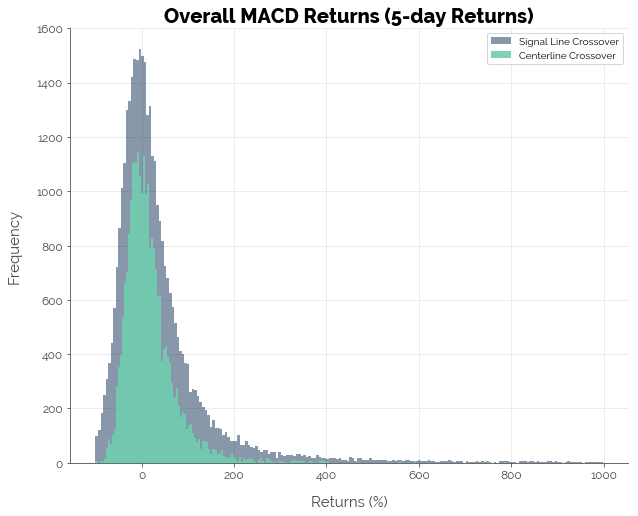

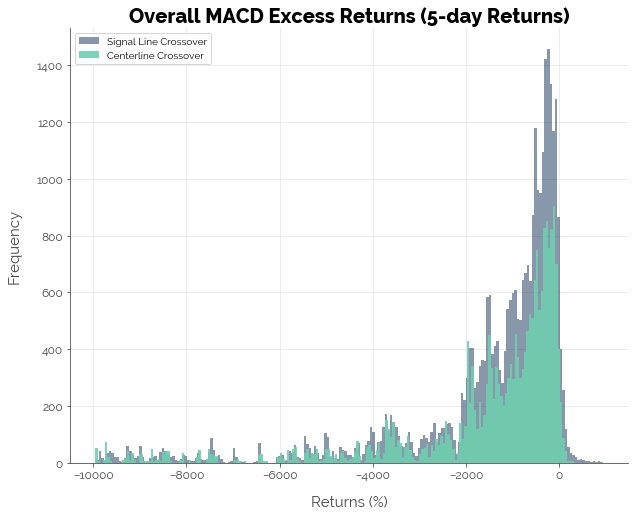

In [4]:
# CODE FOR GRAPHICS NOT INCLUDED

## Precision
Overall, the MACD does not appear to give us any advantage in identifying profitable trades. The first graph shows us that the precision of an MACD-based trading strategy is centered just above 50%: of all profitable trades predicted, slightly more than half of them were actually profitable. The second graph shows that on average, the MACD strategy could not beat naive guesses (the more popular outcome of profitable vs. unprofitable trade). Thus, the data suggests that **the MACD strategy did poorly in identifying profitable trades**. A coin flip would have performed just as well.  

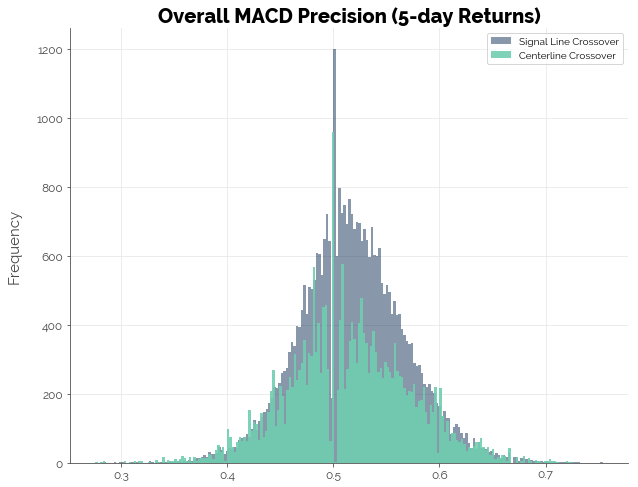

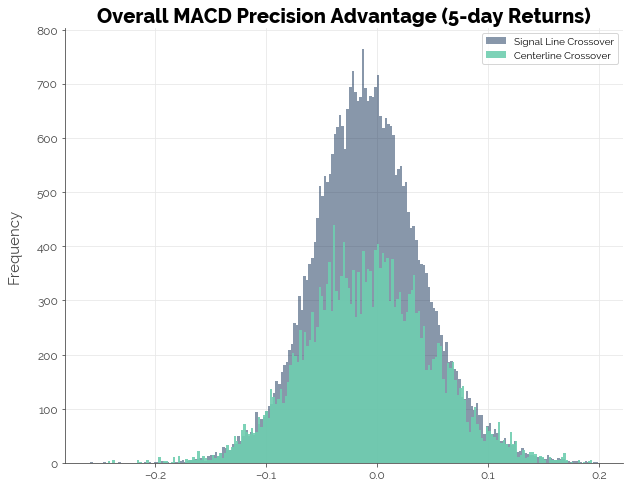

In [5]:
# CODE FOR GRAPHICS NOT INCLUDED

# 10-day Forward Returns

In [6]:
# # Initialise results
# all_res10 = []

# # Collect data on all S&P 500 companies
# for i in np.arange(0, len(sp500.Symbol)):
    
#     # Get symbol
#     stk = sp500.Symbol.iloc[i]
    
#     # Update
#     print('Processing [' + str(i) + '] ' + stk + '...', end = '', flush = True)
    
#     # Simulate trades and append results
#     temp_res = sim_macd_multi(stk, returns = 10)
#     all_res10 += temp_res
    
#     # Convert to df
#     temp_res_df = pd.DataFrame(temp_res)
    
#     # Extract returns
#     cc_exc_ret = str(round(temp_res_df.loc[:, 9].mean(), 2)) + '%'
#     slc_exc_ret = str(round(temp_res_df.loc[:, 15].mean(), 2)) + '%'
    
#     cc_exc_ret = str(round(temp_res_df.loc[:, 9].mean(), 2)) + '%'
#     slc_exc_ret = str(round(temp_res_df.loc[:, 15].mean(), 2)) + '%'
    
#     # Update
#     print('CC Returns: ' + cc_exc_ret + ' | ' + 'SLC Returns: ' + slc_exc_ret)

# # Delete erroneous entries
# all_res10 = [x for x in all_res10 if not np.isnan(x[1])]

# # Consolidate results
# res_df10 = pd.DataFrame(all_res10, columns = ['stock', 'm1', 'm2', 's', 'returns', 'cc_precision', 'cc_recall', 'cc_signals', 'cc_returns',
#                                            'cc_exc_returns', 'cc_std', 'slc_precision', 'slc_recall', 'slc_signals', 
#                                            'slc_returns', 'slc_exc_returns', 'slc_std', 'base_rate', 'n_days'])

# res_df10.dropna(axis = 0, inplace = True)

# # Create ID variable
# res_df10['id'] = res_df10.m1.astype(str) + '_' + res_df10.m2.astype(str) + '_' + res_df10.s.astype(str)

# # Save
# res_df10.to_csv('macd_ret10_results.csv', index = False)
# res_df10 = pd.read_csv('macd_ret10_results.csv')

### Returns
The results for the simulations using 10-day forward returns were not much better. Most strategies could not generate positive excess returns: 6.10% of the strategies using the signal line crossover trigger and 3.23% of the strategies using the centerline crossover trigger delivered positive excess returns.

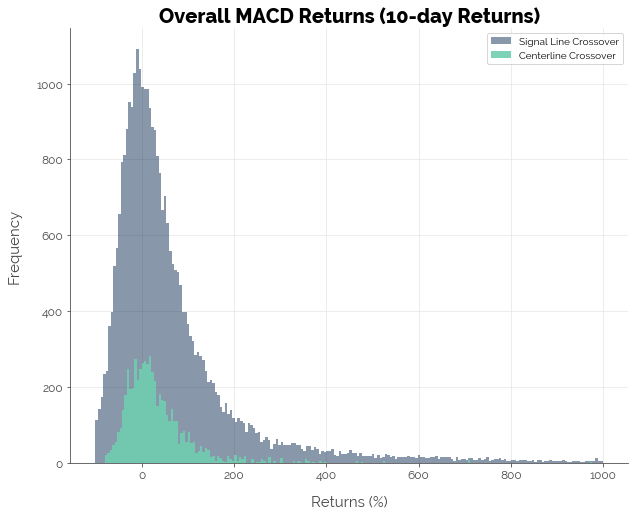

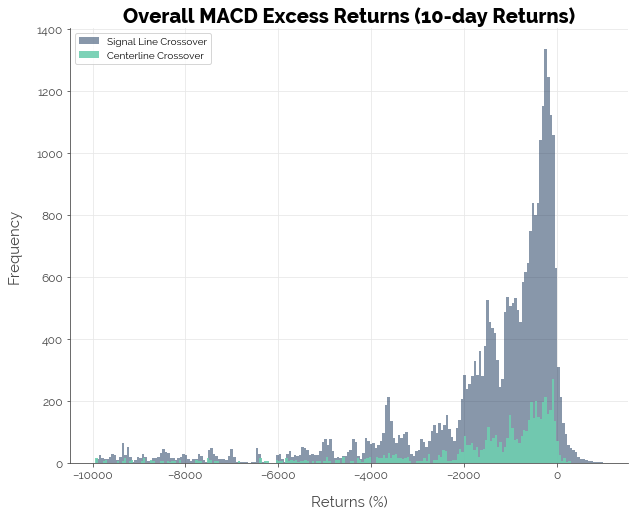

In [7]:
# CODE FOR GRAPHICS NOT INCLUDED

### Precision
Likewise, the results for MACD precision were no better.

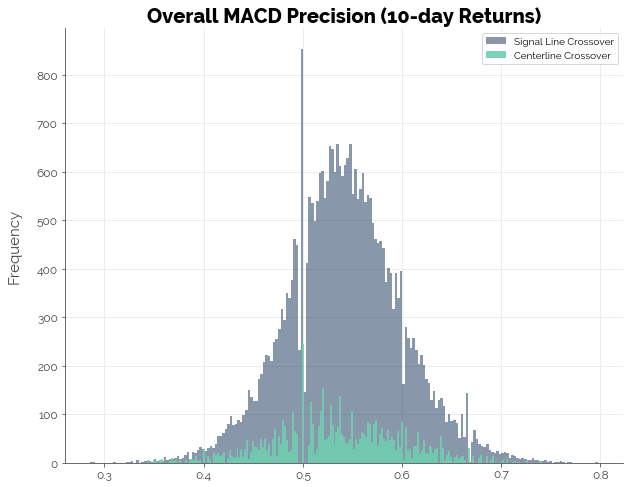

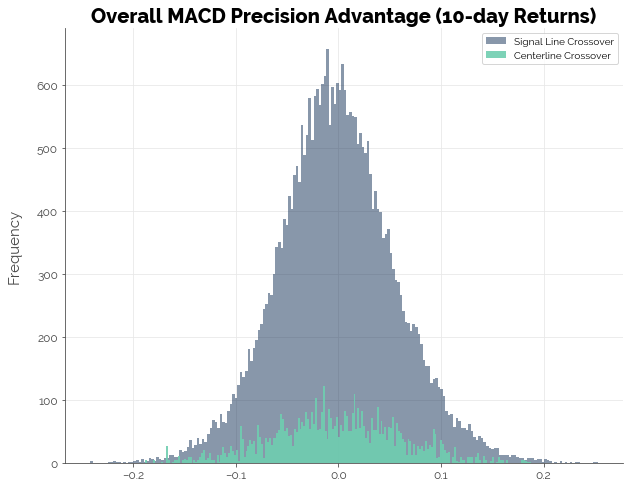

In [8]:
# CODE FOR GRAPHICS NOT INCLUDED

# 20-day Forward Returns

In [9]:
# # Initialise results
# # all_res20 = []

# # Collect data on all S&P 500 companies
# for i in np.arange(489, len(sp500.Symbol)):
    
#     # Get symbol
#     stk = sp500.Symbol.iloc[i]
    
#     # Update
#     print('Processing [' + str(i) + '] ' + stk + '...', end = '', flush = True)
    
#     # Simulate trades and append results
#     temp_res = sim_macd_multi(stk, returns = 20)
#     all_res20 += temp_res
    
#     # Convert to df
#     temp_res_df = pd.DataFrame(temp_res)
    
#     # Extract returns
#     cc_exc_ret = str(round(temp_res_df.loc[:, 9].mean(), 2)) + '%'
#     slc_exc_ret = str(round(temp_res_df.loc[:, 15].mean(), 2)) + '%'
    
#     cc_exc_ret = str(round(temp_res_df.loc[:, 9].mean(), 2)) + '%'
#     slc_exc_ret = str(round(temp_res_df.loc[:, 15].mean(), 2)) + '%'
    
#     # Update
#     print('CC Returns: ' + cc_exc_ret + ' | ' + 'SLC Returns: ' + slc_exc_ret)

# # Delete erroneous entries
# all_res20 = [x for x in all_res20 if not np.isnan(x[1])]

# # Consolidate results
# res_df20 = pd.DataFrame(all_res20, columns = ['stock', 'm1', 'm2', 's', 'returns', 'cc_precision', 'cc_recall', 'cc_signals', 'cc_returns',
#                                            'cc_exc_returns', 'cc_std', 'slc_precision', 'slc_recall', 'slc_signals', 
#                                            'slc_returns', 'slc_exc_returns', 'slc_std', 'base_rate', 'n_days'])

# res_df20.dropna(axis = 0, inplace = True)

# # Create ID variable
# res_df20['id'] = res_df20.m1.astype(str) + '_' + res_df20.m2.astype(str) + '_' + res_df20.s.astype(str)

# # Save
# res_df20.to_csv('macd_ret20_results.csv', index = False)
# res_df20 = pd.read_csv('macd_ret20_results.csv')

### Returns
For the simulations using 20-day forward returns, we observe an **improvement in the number of strategies that generated positive excess returns**. This time, 10.16% of the signal line crossover strategies beat the buy-and-hold benchmark. However, only 2.92% of centerline crossover strategies did so, possibly because of the significantly smaller number of buy signals generated from the longer returns period (recall that the fast and slow EMA for MACD were multiples of the forward returns periods).

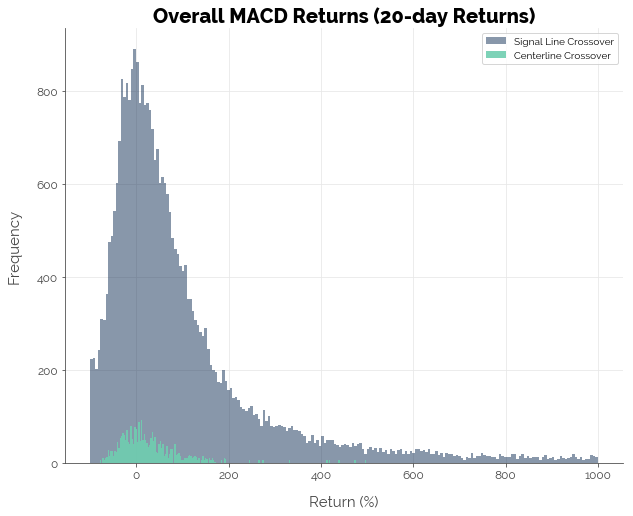

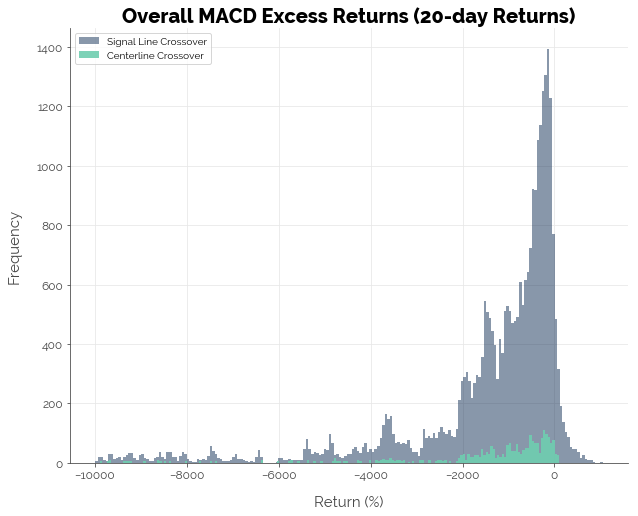

In [10]:
# CODE FOR GRAPHICS NOT INCLUDED

### Precision
Meanwhile, precision of the MACD strategies remained poor.

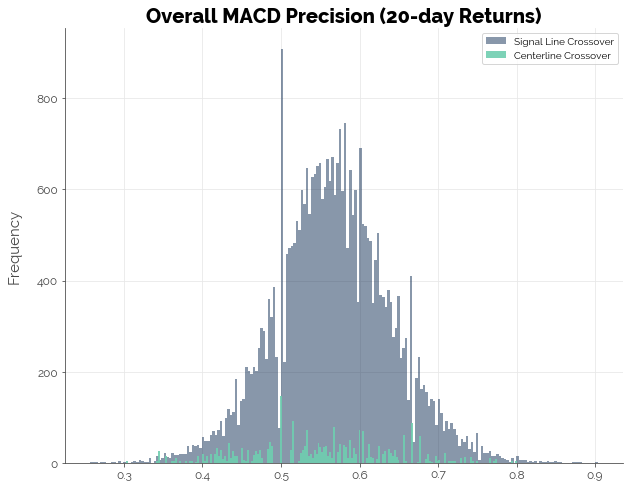

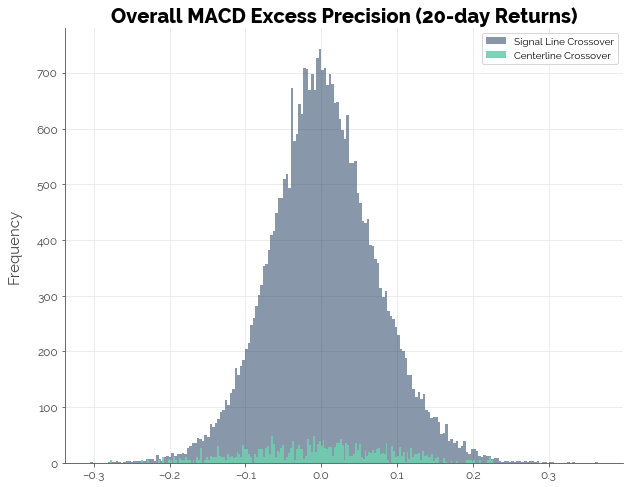

In [11]:
# CODE FOR GRAPHICS NOT INCLUDED

# Conclusion [TLDR]
The graph below summarises the results from our simulations earlier. Essentially, trading the MACD with 5-day, 10-day, and 20-day forward looking returns failed to beat the benchmark: a simple buy-and-hold strategy. We ensured high confidence in the simulations by testing 80 configurations for each of 497 stocks in the S&P 500. At this point, we cannot yet conclude that trading strategies built on existing indicators will fail to deliver positive excess returns. What we can say, though, is that trading strategies should not be built on the MACD alone.

In [12]:
# Calculate means
res_sum = res_df.groupby('stock').slc_exc_returns.mean().reset_index()
res_sum10 = res_df10.groupby('stock').slc_exc_returns.mean().reset_index()
res_sum20 = res_df20.groupby('stock').slc_exc_returns.mean().reset_index()

# Merge datasets
res_all = pd.merge(res_sum, res_sum10, how = 'inner', on = 'stock')
res_all = pd.merge(res_all, res_sum20, how = 'inner', on = 'stock')

# Rename columns
res_all = res_all.rename(columns = {'slc_exc_returns_x': 'returns_5d',
                                   'slc_exc_returns_y': 'returns_10d',
                                   'slc_exc_returns': 'returns_20d'})

# Compute buy-and-hold returns
res_df['returns_bah'] = res_df.cc_returns - res_df.cc_exc_returns

# Subset data
bah_df = res_df[['stock', 'returns_bah']].copy()
bah_df = bah_df.groupby('stock').head(1).reset_index(drop = True)

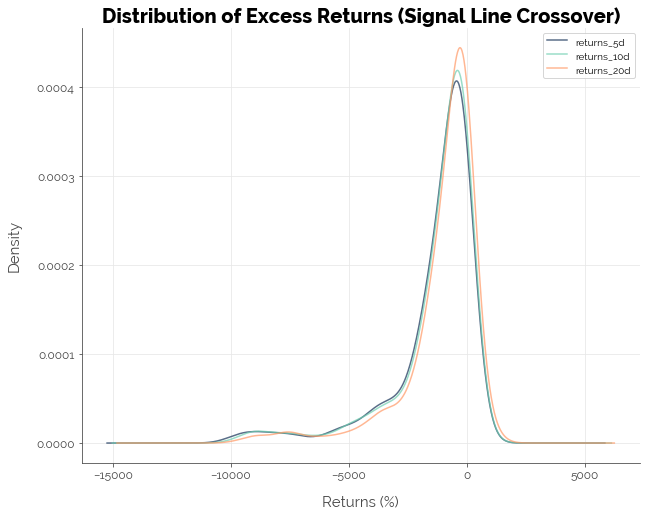

In [13]:
# CODE FOR GRAPHICS NOT INCLUDED